# 1. Enunciado
El archivo reto_precios.csv contiene información sobre precios de departamentos nuevos
dentro de la CDMX, junto con diversas características del inmueble. Para esta pregunta,
requerimos que nos puedas explicar los factores que influyen en el precio por metro cuadrado
de cada vivienda (Hint: Existe información externa que te podría ser útil para resolver esta
pregunta).

# 2. Solución

## 2.1. Configuración e importe de paquetes

In [138]:
!pip install Jinja2
!pip install pandas
!pip install joblib
!pip install matplotlib
!pip install scikit-learn
!pip install folium
!pip install statsmodels
!pip install scipy

c:\Users\leidy\miniconda3\envs\asistencia\Lib\threading.py:979: ResourceWarning: unclosed file <_io.BufferedWriter name=5>
  del self._target, self._args, self._kwargs
c:\Users\leidy\miniconda3\envs\asistencia\Lib\threading.py:979: ResourceWarning: unclosed file <_io.BufferedReader name=6>
  del self._target, self._args, self._kwargs
c:\Users\leidy\miniconda3\envs\asistencia\Lib\threading.py:979: ResourceWarning: unclosed file <_io.BufferedReader name=7>
  del self._target, self._args, self._kwargs
sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x24e15fa12b0>


sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x24e15fa1240>


sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x24e15fa1550>
c:\Users\leidy\miniconda3\envs\asistencia\Lib\site-packages\IPython\utils\_process_win32.py:124: ResourceWarning: unclosed file <_io.BufferedWriter name=5>
  return process_handler(cmd, _system_body)
c:\Users\leidy\miniconda3\envs\asistencia\Lib\site-packages\IPython\utils\_process_win32.py:124: ResourceWarning: unclosed file <_io.BufferedReader name=6>
  return process_handler(cmd, _system_body)
c:\Users\leidy\miniconda3\envs\asistencia\Lib\site-packages\IPython\utils\_process_win32.py:124: ResourceWarning: unclosed file <_io.BufferedReader name=7>
  return process_handler(cmd, _system_body)


sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x24e15fa0bb0>


sys:1: ResourceWarning: Unclosed socket <zmq.Socket(zmq.PUSH) at 0x24e15fa0de0>


In [139]:
import pandas as pd
import os
import matplotlib
import warnings
from joblib import dump, load
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import scipy.stats as stats
import statsmodels.api as sm
import math

from sklearn.ensemble import RandomForestRegressor
import folium

# Ignore all warnings
warnings.filterwarnings("ignore")
# Your Pandas code here
# ...

# Reset warnings filter to default
warnings.resetwarnings()

A continuación se definen las constantes del código, en este caso la ubicación de los datos

In [140]:
DATA_PATH = os.path.join('data')
TARGET = 'price_square_meter'

## 2.2. Carga de datos
Se cuenta con 981 registros no duplicados, descritos con 35 variables. Se observa una muestra de 5 registros

In [141]:
datos = pd.read_csv(os.path.join(DATA_PATH, 'reto_precios (4) (1).csv'))
print('Número de registros duplicados: ', datos.duplicated().sum())
print('Número de filas y columnas:', datos.shape)
datos.head(5)

Número de registros duplicados:  0
Número de filas y columnas: (981, 35)


,main_name,subtitle,link,location,price,attributes,timestamp,id,address,since,...,apartments_per_floor,disposition,parking_lots,floor_situated,orientation,num_bedrooms,department_type,m2,final_price,price_square_meter
0,Departamento - Roma Norte,Departamento en venta,https://departamento.metroscubicos.com/MLM-139...,"Sinaloa 20 , Roma Sur, Roma Sur, Cuauhtémoc, D...",9000000 pesos,"127 m² construidos,2 recs.",2022-03-29,1,"Sinaloa 20 , Roma Sur",Publicado hace 5 días,...,NaN,Contrafrente,2,NaN,NaN,2.0,NaN,127.0,9000000.0,70866.141732
1,Preventa Exclusiva · Terraloza Roma Norte ·,Departamento en venta,https://departamento.metroscubicos.com/MLM-139...,"Tonala, Roma Norte, Cuauhtémoc, Distrito Federal",4264000 pesos,"54 m² construidos,1 rec.",2022-03-29,2,Tonala,Publicado hace 7 días,...,NaN,NaN,1,NaN,NaN,1.0,NaN,54.0,4264000.0,78962.962963
2,Townhouse Único En La Roma Sur,Departamento en venta,https://departamento.metroscubicos.com/MLM-139...,"Tepeji 43, Roma Sur, Ciudad De México, Cdmx, M...",8093500 pesos,"163 m² construidos,3 recs.",2022-03-29,3,"Tepeji 43, Roma Sur, Ciudad De México, Cdmx, M...",Publicado hace 4 días,...,NaN,NaN,2,NaN,NaN,3.0,NaN,163.0,8093500.0,49653.374233
3,"Departamento En Roma Sur, Cuauhtémoc Con 2 Rec...",Departamento en venta,https://departamento.metroscubicos.com/MLM-132...,"Linares, Roma Sur, Cuauhtémoc, Distrito Federal",4000000 pesos,"93 m² construidos,2 recs.",2022-03-29,4,Linares,Publicado hace 5 meses por {action},...,NaN,NaN,1,NaN,Oeste,2.0,Loft,93.0,4000000.0,43010.752688
4,Últimos Deptos En Preventa En Roma Norte,Departamento en venta,https://departamento.metroscubicos.com/MLM-137...,"Frontera, Roma Norte, Cuauhtémoc, Distrito Fed...",6732700 pesos,"103 m² construidos,2 recs.",2022-03-29,5,Frontera,Publicado hace 52 días,...,NaN,NaN,1,NaN,NaN,2.0,NaN,103.0,6732700.0,65366.019417


## 2.3. Selección de variables

### 2.3.1. Cardinalidad
Observamos ahora el número de valores posibles para cada variable, esto es la cardinalidad de cada variable. Aquellas variables con una cardinalidad muy alta no aportan a los diferentes modelos, puesto que no logran generalizar patrones en los datos. Mientras que las variables con cardinalidad baja son aquellas reconocidas como constantes. Se decide eliminar la variable _link_ y las constantes, a saber *subtitle, age_in_years, timestamp, department_type y price_currency*. Se decide mantener la variable _id_ como identificador original de cada registro

In [142]:
aux = pd.DataFrame(datos.nunique().sort_values()).reset_index()
aux.rename(columns={'index':'nombre_columna', 0:'num_valores_unicos'}, inplace=True)
display(aux)
lista_columnas_a_eliminar = list(aux[aux['num_valores_unicos'] == 1]['nombre_columna'])
datos = datos.set_index('id')

,nombre_columna,num_valores_unicos
0,subtitle,1
1,age_in_years,1
2,timestamp,1
3,department_type,1
4,price_currency,1
5,cellars,2
6,since_period,3
7,parking_lots,3
8,disposition,3
9,num_bedrooms,4


### 2.3.2. Columnas no numéricas duplicadas
Las columnas duplicadas y cuyos tipos de datos son no numérico se verifican a partir de si los valores de una de las columnas están contenidos en la otra y se requiere conocimiento de negocio o de los datos para identificar las posibles variables correlacionadas. Se decide eliminar las variables *price, price_mod y address* y mantener las variables *final_price y location* ya que estas últimas contienen la información de las primeras

In [143]:
def verificar_columnas(_df, _col_1, _col_2):
    aux = datos[[_col_1, _col_2]]
    aux['verificacion'] = aux.apply(lambda x: x[_col_2] in x[_col_1], axis=1)
    aux = aux.verificacion.value_counts()[0]
    if aux==len(_df):
        print(f'La variable {_col_1} contiene la información de la variable {_col_2}')
        return True
    return False

In [144]:
datos['final_price'] = datos['final_price'].astype('int').astype('str')
if verificar_columnas(datos, 'price', 'final_price'):
    datos.drop('price', inplace=True, axis=1)

La variable price contiene la información de la variable final_price


C:\Users\leidy\AppData\Local\Temp\ipykernel_14580\1915071143.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux['verificacion'] = aux.apply(lambda x: x[_col_2] in x[_col_1], axis=1)


In [145]:
aux = datos[['final_price','price_mod']]
aux['verificacion'] = aux['final_price'] == aux['price_mod']
aux = aux.verificacion.value_counts()[0]
aux

C:\Users\leidy\AppData\Local\Temp\ipykernel_14580\20995432.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux['verificacion'] = aux['final_price'] == aux['price_mod']


981

In [146]:
datos['address'] = datos['address'].fillna('')
if verificar_columnas(datos, 'address', 'location'):
    datos.drop('address', inplace=True, axis=1)

La variable address contiene la información de la variable location


C:\Users\leidy\AppData\Local\Temp\ipykernel_14580\1915071143.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux['verificacion'] = aux.apply(lambda x: x[_col_2] in x[_col_1], axis=1)


En el caso de la variable *since* se descompone en las variables since_period y since_value por lo que se decide eliminar

In [147]:
datos[['since', 'since_period', 'since_value']].drop_duplicates()

,since,since_period,since_value
id,,,
1,Publicado hace 5 días,days,5
2,Publicado hace 7 días,days,7
3,Publicado hace 4 días,days,4
4,Publicado hace 5 meses por {action},months,5
5,Publicado hace 52 días,days,52
...,...,...,...
718,Publicado hace 16 días,days,16
821,Publicado hace 9 días,days,9
852,Publicado hace 29 días,days,29


In [148]:
datos = datos.drop(['link', 'price_mod', 'since']+lista_columnas_a_eliminar, axis=1)
datos['final_price'] = datos['final_price'].astype('int')

Ahora se verifica que las variables *num_bedrooms* y *m2* contengan la información de la variable *attributes*, al ser correcto se decide eliminar la variable *attributes*

In [149]:
aux = datos[['attributes', 'num_bedrooms']]
aux['num_bedrooms'] = aux['num_bedrooms'].astype('int')
aux['possible_num_bedrooms'] = aux['attributes'].apply(lambda x: int(x.split(',')[1].split(' ')[0]) if 'rec' in x else 0)
aux['verificacion'] = aux['num_bedrooms'] == aux['possible_num_bedrooms']
display(aux[aux['verificacion'] == False])
value = aux.verificacion.value_counts()[0]
value

C:\Users\leidy\AppData\Local\Temp\ipykernel_14580\739550756.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux['num_bedrooms'] = aux['num_bedrooms'].astype('int')
C:\Users\leidy\AppData\Local\Temp\ipykernel_14580\739550756.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux['possible_num_bedrooms'] = aux['attributes'].apply(lambda x: int(x.split(',')[1].split(' ')[0]) if 'rec' in x else 0)
C:\Users\leidy\AppData\Local\Temp\ipykernel_14580\739550756.py:4: SettingWithCopyWarning: 
A value is trying t

,attributes,num_bedrooms,possible_num_bedrooms,verificacion
id,,,,
416,141 m² construidos,2,0,False
546,"7,210 m² construidos,2 recs.",2,210,False
589,80 m² construidos,2,0,False
606,64 m² construidos,2,0,False
624,34 m² construidos,2,0,False
636,100 m² construidos,2,0,False
722,93 m² construidos,2,0,False
793,153 m² construidos,2,0,False
794,40 m² construidos,2,0,False


970

In [150]:
aux = datos[['attributes', 'm2']]
aux['m2'] = aux['m2'].astype('int').astype('str')
aux['verificacion'] = aux.apply(lambda x: x['m2'] in x['attributes'], axis=1)
display(aux[aux['verificacion'] == False])
value = aux.verificacion.value_counts()[0]
value

C:\Users\leidy\AppData\Local\Temp\ipykernel_14580\1857225466.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux['m2'] = aux['m2'].astype('int').astype('str')
C:\Users\leidy\AppData\Local\Temp\ipykernel_14580\1857225466.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux['verificacion'] = aux.apply(lambda x: x['m2'] in x['attributes'], axis=1)


,attributes,m2,verificacion
id,,,
546,"7,210 m² construidos,2 recs.",7210,False


980

In [151]:
datos.drop(['attributes'], axis=1, inplace=True)
print(datos.duplicated().sum())
datos.drop_duplicates(inplace=True)

4


Se eliminan todas las variables que tengan un porcentaje de completitud menor al 10%

In [157]:
aux = datos.isna().sum().sort_values()
display(aux.tail(6))

num_floors              893
cellars                 925
floor_situated          953
disposition             957
apartments_per_floor    962
orientation             969
dtype: int64

In [158]:
aux = aux[aux>=datos.shape[0]*0.9]

datos.drop(list(aux.index), axis=1, inplace=True)

A continuación se evalua la correlación lineal se Spearman, dado que esta no se ve afectada por la presencia de valores atípicos y soporta distribuciones diferentes a la normal. Se observa que las correlaciones van desde -0.37 a 0.78, no se decide eliminar ninguna variable por correlación

In [ ]:
corr = datos.drop(['vendor', 'description', 'monthly_fee', 'location', 'since_period', 'main_name'], axis=1).corr(method='spearman')
corr.style.background_gradient(cmap='coolwarm')

,lat,lon,since_value,days_on_site,amenities,bathrooms,parking_lots,num_bedrooms,m2,final_price,price_square_meter
lat,1.000000,0.213847,-0.042741,0.035264,-0.066499,-0.160628,-0.163974,-0.166215,-0.172724,-0.169473,0.074677
lon,0.213847,1.000000,-0.062055,-0.085512,-0.082831,-0.027860,-0.014193,-0.041954,-0.044953,-0.019172,0.080594
since_value,-0.042741,-0.062055,1.000000,-0.375780,-0.054665,-0.031121,-0.002920,-0.050488,-0.078949,-0.090151,-0.086840
days_on_site,0.035264,-0.085512,-0.375780,1.000000,0.185535,0.105163,0.103743,0.159187,0.203749,0.135170,-0.059964
amenities,-0.066499,-0.082831,-0.054665,0.185535,1.000000,0.636650,0.395733,0.733238,0.679758,0.538768,-0.344014
bathrooms,-0.160628,-0.027860,-0.031121,0.105163,0.636650,1.000000,0.291748,0.638377,0.650777,0.573354,-0.189224
parking_lots,-0.163974,-0.014193,-0.002920,0.103743,0.395733,0.291748,1.000000,0.315256,0.516986,0.537427,-0.008071
num_bedrooms,-0.166215,-0.041954,-0.050488,0.159187,0.733238,0.638377,0.315256,1.000000,0.613166,0.423893,-0.334810
m2,-0.172724,-0.044953,-0.078949,0.203749,0.679758,0.650777,0.516986,0.613166,1.000000,0.787844,-0.326771
final_price,-0.169473,-0.019172,-0.090151,0.135170,0.538768,0.573354,0.537427,0.423893,0.787844,1.000000,0.222618


Se observa a detalle las correlaciones para la variable objetivo

In [ ]:
corr.loc[[TARGET]]

,lat,lon,since_value,days_on_site,amenities,bathrooms,parking_lots,num_bedrooms,m2,final_price,price_square_meter
price_square_meter,0.074677,0.080594,-0.08684,-0.059964,-0.344014,-0.189224,-0.008071,-0.33481,-0.326771,0.222618,1.0


Se verifica que la multiplicacion de m2 con la varibale objetivo es igual al valor de la variable final_price, es decir, esta es la solución base del problema. Siguiendo esta formula se puede predecir el valor del metro cuadrado sin necesidad de un modelo de aprendizaje automático. Dado lo anterior, se pueden eliminar las variables *m2 y final_price* o se peuden mantener, por ahora se decide mantener y comprobar si los modelos identifican esta dependencia entre las variables

In [159]:
aux = datos[['m2', TARGET, 'final_price']]
aux['verificacion'] = aux['m2'] * aux[TARGET] 

aux['verificacion'] = aux['verificacion'].round(0) == aux['final_price']
aux = aux.verificacion.value_counts()[0]
print('Número de registros cuya variable objetivo price_square_meter es igual a la multiplicación de m2 y final_price:', aux)
print('Número de registros actuales:', len(datos))

Número de registros cuya variable objetivo price_square_meter es igual a la multiplicación de m2 y final_price: 977
Número de registros actuales: 977


C:\Users\leidy\AppData\Local\Temp\ipykernel_14580\1450614467.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux['verificacion'] = aux['m2'] * aux[TARGET]
C:\Users\leidy\AppData\Local\Temp\ipykernel_14580\1450614467.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux['verificacion'] = aux['verificacion'].round(0) == aux['final_price']


## 2.4. Lasso
El primer modelo a verificar es Lasso una regresión lineal con penalización, cuyos resultados de coeficientes permiten determinar si una variable es relevante linealmente o no en la predicción de la variable objetivo

In [ ]:
datos_completos = datos.copy()
datos = datos.drop(['vendor', 'description', 'monthly_fee', 'location', 'since_period', 'main_name','amenities'], axis=1)
train, test = train_test_split(datos, test_size=0.2, random_state=33)
train_m, val = train_test_split(train, test_size=0.2, random_state=33)

X_train, y_train = train_m.drop(TARGET, axis=1), train_m[TARGET]

Para entrenar el modelo se utiliza un pipeline con gridsearch, el cual va a realizar entrenamientos para diferentes combinaciones de hiperparámetros y en cada entrenamiento realizará validación cruzada con 5 subdivisiones. Se utiliza validación cruzada para evitar el sobreajuste del modelo a los datos de entrenamiento

In [ ]:
estimators = [
        ('normalizar',StandardScaler()),
        ('regresion', Lasso(random_state=33))          
    ]

pipe = Pipeline(estimators)

parameters = {
              'regresion__alpha': [0.001, 0.01, 0.1, 1, 10, 100],
              'normalizar': [StandardScaler(), MinMaxScaler(), MaxAbsScaler(), 'passthrough']
              }

grid_search = GridSearchCV(pipe, parameters, verbose=2, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print(best_model)

display(pd.DataFrame(grid_search.cv_results_))

print('Coefficients: ', best_model['regresion'].coef_)
print('Intercept: ',best_model['regresion'].intercept_)

coef = dict(zip(X_train.columns, best_model['regresion'].coef_))
coef

Fitting 5 folds for each of 24 candidates, totalling 120 fits


Pipeline(steps=[('normalizar', MaxAbsScaler()),
                ('regresion', Lasso(alpha=10, random_state=33))])


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_normalizar,param_regresion__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.033023,0.007305,0.009260,0.001146,StandardScaler(),0.001,"{'normalizar': StandardScaler(), 'regresion__a...",-7.143177e+09,-9.473670e+07,-6.183315e+07,-1.190366e+08,-4.060367e+07,-1.491877e+09,2.825778e+09,24
1,0.031649,0.009393,0.008787,0.000445,StandardScaler(),0.01,"{'normalizar': StandardScaler(), 'regresion__a...",-7.131402e+09,-9.473637e+07,-6.183326e+07,-1.190365e+08,-4.060370e+07,-1.489522e+09,2.821068e+09,21
2,0.027204,0.006919,0.009524,0.002125,StandardScaler(),0.1,"{'normalizar': StandardScaler(), 'regresion__a...",-7.014194e+09,-9.473314e+07,-6.183434e+07,-1.190362e+08,-4.060406e+07,-1.466080e+09,2.774187e+09,18
3,0.029337,0.009425,0.009092,0.001373,StandardScaler(),1,"{'normalizar': StandardScaler(), 'regresion__a...",-5.896431e+09,-9.470110e+07,-6.184502e+07,-1.190332e+08,-4.060762e+07,-1.242524e+09,2.327109e+09,14
4,0.026574,0.006144,0.008683,0.000605,StandardScaler(),10,"{'normalizar': StandardScaler(), 'regresion__a...",-7.804362e+07,-9.437919e+07,-6.195222e+07,-1.190047e+08,-4.064418e+07,-7.880478e+07,2.683064e+07,10
5,0.024931,0.002284,0.009347,0.002033,StandardScaler(),100,"{'normalizar': StandardScaler(), 'regresion__a...",-4.998324e+07,-9.140669e+07,-6.327226e+07,-1.188625e+08,-4.106435e+07,-7.291780e+07,2.858820e+07,7
6,0.025326,0.004339,0.009930,0.001339,MinMaxScaler(),0.001,"{'normalizar': MinMaxScaler(), 'regresion__alp...",-7.138011e+09,-9.473648e+07,-6.183321e+07,-1.190366e+08,-4.060370e+07,-1.490844e+09,2.823712e+09,22
7,0.026538,0.006079,0.008647,0.001978,MinMaxScaler(),0.01,"{'normalizar': MinMaxScaler(), 'regresion__alp...",-7.079875e+09,-9.473419e+07,-6.183384e+07,-1.190368e+08,-4.060401e+07,-1.479217e+09,2.800458e+09,19
8,0.026643,0.006141,0.009268,0.001234,MinMaxScaler(),0.1,"{'normalizar': MinMaxScaler(), 'regresion__alp...",-6.511803e+09,-9.471149e+07,-6.184016e+07,-1.190383e+08,-4.060716e+07,-1.365600e+09,2.573242e+09,15
9,0.025717,0.005256,0.009019,0.000876,MinMaxScaler(),1,"{'normalizar': MinMaxScaler(), 'regresion__alp...",-2.145786e+09,-9.448404e+07,-6.190346e+07,-1.190544e+08,-4.063923e+07,-4.923734e+08,8.271426e+08,11


Coefficients:  [     -0.               0.           -2097.77592362   -3988.39802779
  -11338.50238371    -381.87223624  -16340.28161462 -132755.68263628
  177052.86238307]
Intercept:  69022.18487550551


{'lat': -0.0,
 'lon': 0.0,
 'since_value': -2097.7759236196316,
 'days_on_site': -3988.398027793308,
 'bathrooms': -11338.502383710194,
 'parking_lots': -381.87223624313395,
 'num_bedrooms': -16340.281614623082,
 'm2': -132755.6826362838,
 'final_price': 177052.8623830676}

In [174]:
aux = pd.DataFrame(coef, index=[0]).T
aux.columns = ['Coeficiente']
aux

,Coeficiente
lat,-0.000000
lon,0.000000
since_value,-2097.775924
days_on_site,-3988.398028
bathrooms,-11338.502384
parking_lots,-381.872236
num_bedrooms,-16340.281615
m2,-132755.682636
final_price,177052.862383


Como se observa en los coeficientes anteriores parece que la longitud y la latitud no son relevantes en la predicción del precio por metro cuadrado, para verificar esto se decide mostrar en un mapa las ubicaciones de las viviendas, se observa que la mayoría se encuentran en las mismas zonas de ciudad de Mexico, por lo cual parece que tiene sentido que el precio no varie debidoa su cercania. También se identifica que las variables con mayor peso son m2 y final_price

In [ ]:
# Crear un objeto de mapa centrado en una ubicación inicial
map_center = [19.42847, -99.12766]  # Coordenadas del centro del mapa
mapa = folium.Map(location=map_center, zoom_start=10)  # Ajusta el valor de zoom_start según lo necesario

# Agregar puntos al mapa
for i, row in datos.iterrows():
    folium.Marker(
        location=[row["lat"], row["lon"]],
        popup='Punto '+str(i),
    ).add_to(mapa)

# Guardar el mapa en un archivo HTML
display(mapa)
mapa.save("mapa.html")

Terminando el ejercicio, se obtienen las métricas de desepeño para el mejor modelo asi cómo se observa el comportamiento de la predicción versus los valores reales

Sobre entrenamiento tenemos un valor de RMSE igual a 8045.84, es decir la diferencia promedio entre los valores estimados y los reales es de 8045 pesos mexicanos, con un r2 de 0.829 lo que significa que el 82.9% de la variabilidad  en la variable objetivo es tomada en cuenta por la combinación lineal entre esta y las variables predictoras.

En el caso del validación tenemos un valor de RMSE igual a 226.714 pesos mexicanos, es decir la diferencia promedio entre los valores estimados y los reales es de 226.714, con un r2 de 0.06714 lo que significa que el 6,71% de la variabilidad  en la variable  respuesta es tomada en cuenta por la combinación lineal entre esta y las variables predictoras.

El error en entrenamiento es más alto que al usar el data set de validació, podemos concluir que el modelo no es confiable, ya que el nivel de error cuando aprende es alto no se puede garantizar que haga una buena predicción o que sea solo suerte.

In [ ]:
y_pred = best_model.predict(X_train)
n,p = X_train.shape

print('------------ Regresión Lasso con entrenamiento------------')
print("Residual sum of squares (MSE): %.2f" % mean_squared_error(y_train,y_pred))
print("R2-score: %.5f" % r2_score(y_train, y_pred) )
print("Adj R2-score: %.5f" % ( 1-(1-r2_score(y_train, y_pred))*(n-1)/(n-p-1)) )

X_val, y_val = val.drop(TARGET, axis=1), val[TARGET]
y_pred2 = best_model.predict(X_val)
print(y_pred2)

n,p = X_val.shape

print('------------ Regresión Lasso con validación ------------')
print("Residual sum of squares (MSE): %.2f" % mean_squared_error(y_val,y_pred2))
print("R2-score: %.5f" % r2_score(y_val, y_pred2) )
print("Adj R2-score: %.5f" % ( 1-(1-r2_score(y_val, y_pred2))*(n-1)/(n-p-1)) )

------------ Regresión Lasso con entrenamiento------------
Residual sum of squares (MSE): 64735603.36
R2-score: 0.82922
Adj R2-score: 0.82671
[ 7.14607655e+04  5.01749632e+04  7.05938808e+04  2.24248777e+04
  6.57784682e+04  9.56695259e+04  6.64845086e+04  7.16584367e+04
  6.07106041e+04  6.24723131e+04  6.03105686e+04  7.42371684e+04
  4.57276882e+04  6.99422781e+04  5.98132459e+04  7.99896291e+04
  7.00499352e+04  6.23891246e+04  6.89579146e+04  5.49811367e+04
  4.42149808e+04  7.77485473e+04  2.60315235e+03  6.52779098e+04
  5.82130930e+04  7.00499352e+04  8.26013682e+04  4.87435629e+04
  6.85627663e+04  5.71569280e+04  6.88652435e+04  6.54042540e+04
  6.99703536e+04  8.29320443e+04  6.01629370e+04  6.81979022e+04
  5.93976232e+04  7.45533552e+04  7.30626607e+04  5.92468292e+04
  6.37818989e+04  2.91393362e+04  8.11020586e+04  6.22383878e+04
  6.60835598e+04  6.07698961e+04  5.18049776e+04  6.82431477e+04
  7.15182927e+04  5.74724993e+04  3.64067573e+04  6.61421543e+04
  5.76559170e

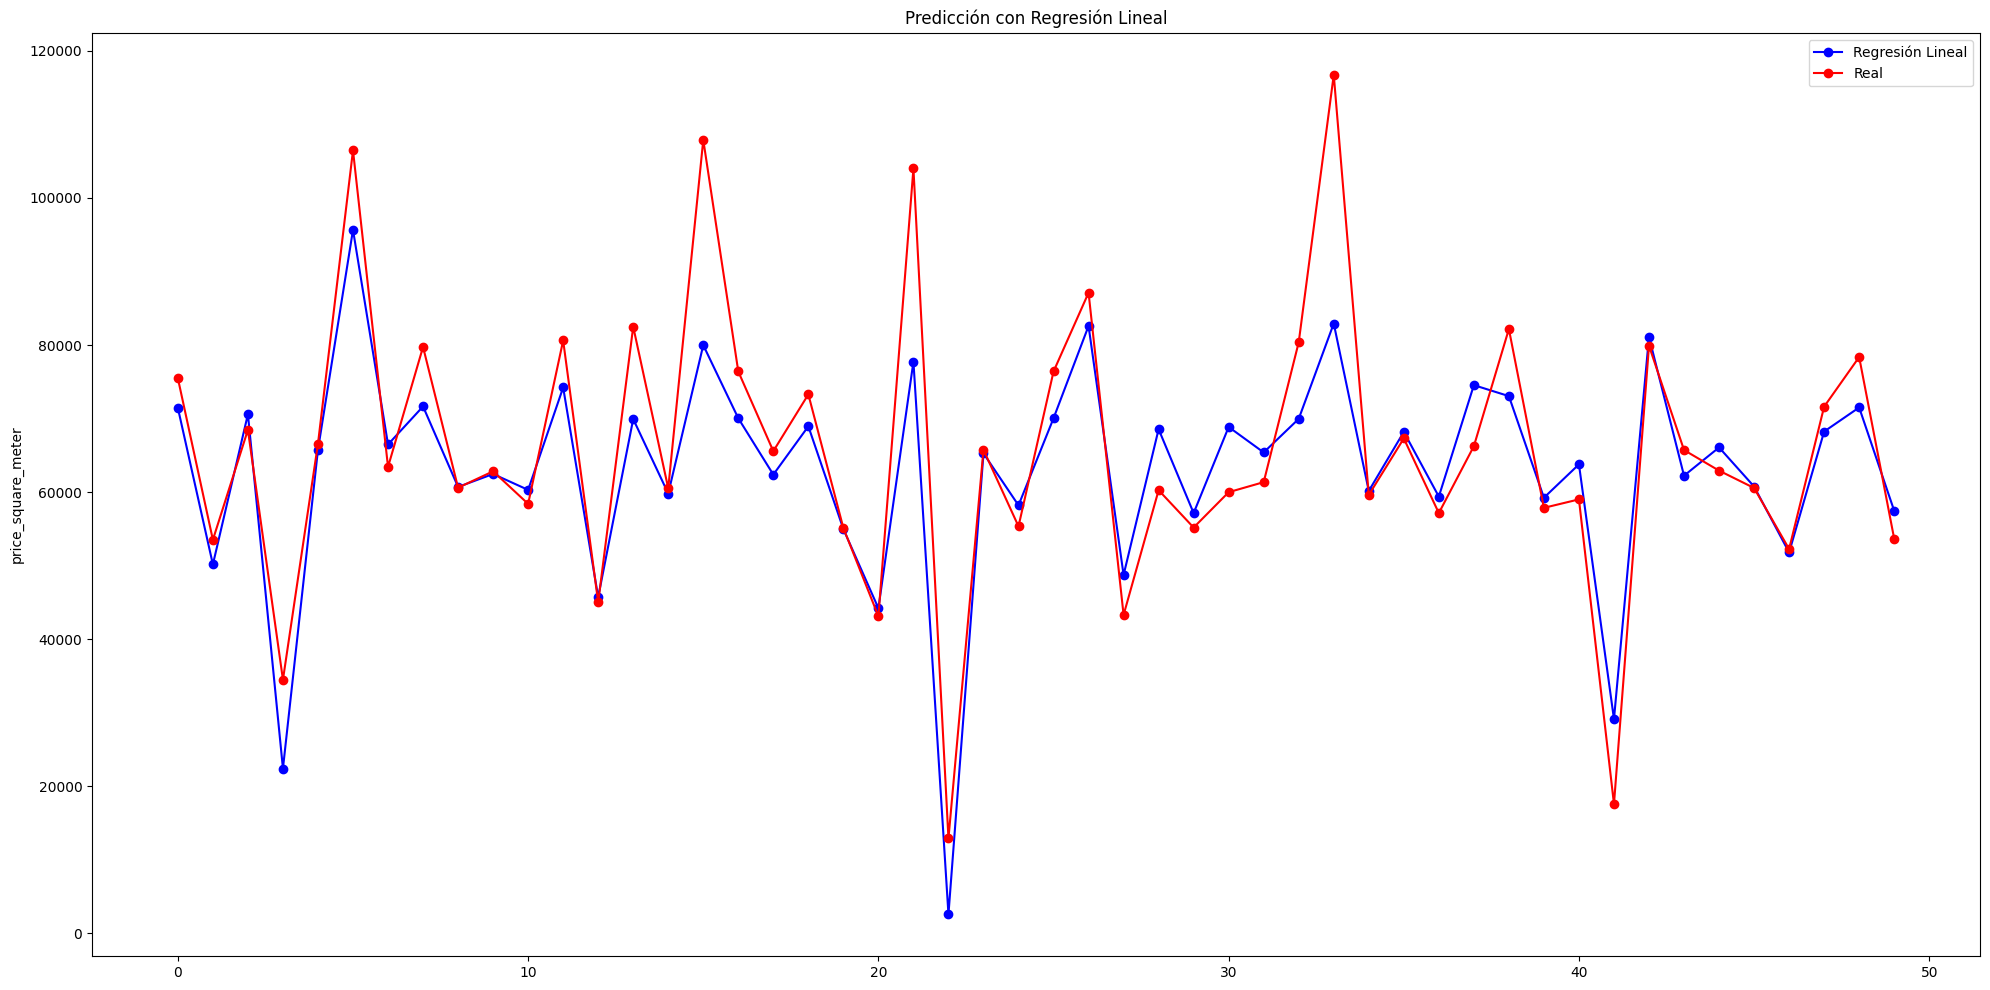

In [ ]:
%matplotlib inline
fig, axs = plt.subplots(1,figsize=(20,10))

xvals = list(range(len(y_val[:50])))
axs.plot(xvals, y_pred2[:50],'bo-', label='Regresión Lineal')
axs.plot(xvals, y_val[:50],'ro-', label='Real')

axs.set(title='Predicción con Regresión Lineal',ylabel=y_train.name)
axs.legend()

plt.tight_layout()
plt.show()

In [ ]:
dump(best_model,'lasso_regressor.pkl')

model = load('lasso_regressor.pkl') 
model

Pipeline(steps=[('normalizar', MaxAbsScaler()),
                ('regresion', Lasso(alpha=10, random_state=33))])

## 2.5. Árboles de decisión

                                Feature  Importance
8                           final_price    0.621628
7                                    m2    0.340106
0                                   lat    0.006759
1                                   lon    0.006237
6                          num_bedrooms    0.005588
2                           since_value    0.004612
3                          days_on_site    0.003132
139     vendor_Skgasesoresinmobiliarios    0.002201
22            vendor_Buscatuhogarmexico    0.001619
125  vendor_Realtyworld Herrerapalacios    0.001520
5                          parking_lots    0.001110
4                             bathrooms    0.000778


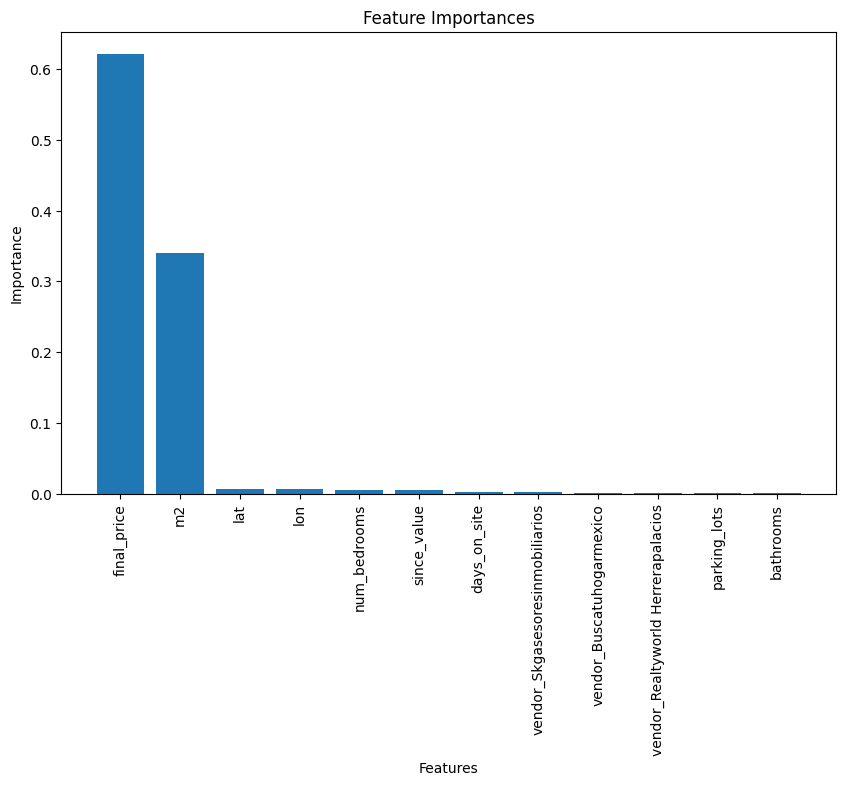

In [ ]:
# Separate features and target variable
X = pd.get_dummies(datos_completos.drop(['description', 'monthly_fee', 'location', 'since_period', 'main_name','amenities']+[TARGET], axis=1))
y = datos_completos[TARGET]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Regressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model on the training data
rf_regressor.fit(X_train, y_train)

# Get feature importances
feature_importances = rf_regressor.feature_importances_

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})

# Sort the features by importance
feature_importance_df = feature_importance_df[feature_importance_df['Importance']>0.0006].sort_values(by='Importance', ascending=False)

# Print the sorted feature importances
print(feature_importance_df)

# Plotting the feature importances
plt.figure(figsize=(10, 6))
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()


## 2.6. ANOVA
Se realizan pruebas ANOVA de una via con los respectivos supuesto y pruebas para verificar 

In [ ]:
# Funcion para realizar el analisis de varianza de una via variable por variable, recibe la cartera seleccionada por el asesor y la variable a verificar
# Cada factor (variable independiente) tiene un nivel N determinado por la cantidad de valores posibles 
def anova_una_via(_aux, _variable_a_evaluar, _plot = False):
    lis = []
       
    # TODO: Sería bueno que esto quedara para todas las variables, es decir por fuera del if
    # Las funciones stats.f_oneway recibe los grupos y retorna el F-value y el p-value, determina si las medias de los grupos son iguales o no
    if _variable_a_evaluar in ['vendor','description', 'monthly_fee', 'location', 'since_period', 'main_name']:
        ops = _aux.pivot_table(index=_aux.index, columns = _variable_a_evaluar, values = TARGET)
        for col in ops.columns:
            if col not in [_variable_a_evaluar, TARGET]:
                lis.append(ops[col])
                
    if _plot:
        _aux.boxplot(grid = True)
        plt.show()
    # Modelo Ordinary Least Squares (OLS)
    model = ols(TARGET+' ~ C('+_variable_a_evaluar+')', data = _aux).fit()

    ## ------------------------------------------------------------- SUPUESTOS DE ANOVA
    supuestos = True
    # La prueba de Levene se puede utilizar para verificar la homogeneidad de las varianzas. Hipótesis nula: las muestras de poblaciones tienen varianzas iguales
    if len(lis)>0:
        w, pvalue = stats.levene(*lis)
        if not math.isnan(w) and  not math.isnan(pvalue):
            print('P-value de la prueba Levene: ', pvalue)
        if pvalue >= 0.05:#Significativo = rechazar hipotesis nula
            supuestos = False

    #La prueba de Shapiro-Wilk se puede usar para verificar la distribución normal de los residuos. Hipótesis nula: los datos provienen de una distribución normal
    w, pvalue = stats.shapiro(model.resid)
    if not math.isnan(w) and  not math.isnan(pvalue):
        print('P-value de la prueba Shapiro-Wilk: ', pvalue)
    if pvalue >= 0.05:#Significativo = rechazar hipotesis nula
        supuestos = False
    ## ------------------------------------------------------------- FIN SUPUESTOS DE ANOVA
    # Si no se cumplen los supuestos nisiquiera se intenta el anova
    # TODO: en el else podria ir Lasso (regresion regularizada) o lo que hizo Luis -se supone que nos envio los links pero no lo he revisado-
    #supuestos=True
    if supuestos:
        anova_table = sm.stats.anova_lm(model, typ = 1)
        print('Resultados ANOVA:')
        print(anova_table)

        if anova_table.loc['C('+_variable_a_evaluar+')']['PR(>F)'] < 0.05:
            print('-'*100)
            print('El valor P obtenido del análisis ANOVA es significativo (P >= 0.05) y, por lo tanto,\n concluimos que existen diferencias significativas entre los '+_variable_a_evaluar)
            print('-'*100)
            return True, _variable_a_evaluar
        else:# TODO: 
            print('-'*100)
            print('El valor P obtenido del análisis ANOVA no es significativo (P >= 0.05) y, por lo tanto,\n concluimos que no existen diferencias significativas entre los '+_variable_a_evaluar)
            print('-'*100)
#            print('Fin: ',datetime.now())
            return False, None
    else:# TODO: Aqui agregar Lasso o Luis
        print('-'*100)
        print('No se cumplen con los supuestos para hacer anova')
        print('-'*100)
#        print('Fin: ',datetime.now())
        return False, None


In [ ]:
variables_a_mantener = []
for col in datos_completos.columns:
        try:
            res, var = anova_una_via(datos[[TARGET, col]], col)
            if res:
                variables_a_mantener.append(var)
        except Exception as e:
            print(col, e)
variables_a_mantener

P-value de la prueba Shapiro-Wilk:  3.541081219348813e-42
Resultados ANOVA:
                 df        sum_sq       mean_sq         F   PR(>F)
C(main_name)  666.0  2.146191e+11  3.222509e+08  0.668076  0.99999
Residual      314.0  1.514599e+11  4.823562e+08       NaN      NaN
----------------------------------------------------------------------------------------------------
El valor P obtenido del análisis ANOVA no es significativo (P >= 0.05) y, por lo tanto,
 concluimos que no existen diferencias significativas entre los main_name
----------------------------------------------------------------------------------------------------
P-value de la prueba Shapiro-Wilk:  2.788380002631332e-21
Resultados ANOVA:
                df        sum_sq       mean_sq         F        PR(>F)
C(location)  180.0  2.335697e+11  1.297609e+09  7.834078  3.797759e-95
Residual     800.0  1.325092e+11  1.656365e+08       NaN           NaN
----------------------------------------------------------------------

['location',
 'description',
 'vendor',
 'lat',
 'lon',
 'since_period',
 'since_value',
 'days_on_site',
 'amenities',
 'bathrooms',
 'num_bedrooms',
 'm2',
 'final_price']

Las variables que son estadísticamente significativas para este grupo son _'location', 'description', 'vendor', 'lat', 'lon', 'since_period', 'since_value', 'days_on_site', 'amenities','bathrooms','num_bedrooms', 'm2', 'final_price'_, puesto que todos sus _p-value_ (PR(>F)) son menores que 0.05, esto significa que hay diferencias significativas entre alguno de los grupos de cada variable 

# 3. Conclusiones
since_value, days_on_site, bathrooms, parking_lots, num_bedrooms, m2, final_price

final_price, m2, lon, lat, since_value, num_bedrooms, days_on_site, parking_lots, bathrooms

location, description, vendor, lat, lon, since_period, since_value, days_on_site, amenities, bathrooms,num_bedrooms, m2, final_price